## Introduction

In this project, we aim to use sentiment analysis predict a review's rating based on the comment text. Specifically, we use data scraped from [boardgamegeek.com](https://boardgamegeek.com/) consisting of reviews for board games. 

Each row of the data is a review, containing the board game's product id, the reviewer's user id, a 1-10 rating, and a comment. Comments with fewer than three characters were removed, as were the vast majority of non-English comments.

We build a few predictive models, of increasing sophistication, to estimate ratings based on input derived from only the comments.

## Import and Basic Cleaning

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import pickle
import re

from matplotlib import pyplot as plt
from sklearn import linear_model, neural_network, preprocessing
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

We first read the data into dataframes, and rename the columns with a standard naming convention. Then we do an initial cleanup of the data by removing a small number of reviews that have rating values of less than 1, which are invalid.

In [2]:
### read data into pandas DataFrame
sample_df = pd.read_csv('data/boardgame-comments-sample.csv', header=0)

### the full training set is over Github size limit, so have to load in chunks
full_df_1  = pd.read_csv('data/boardgame-comments-english-part1.csv', header=0)
full_df_2  = pd.read_csv('data/boardgame-comments-english-part2.csv', header=0)
full_df_3  = pd.read_csv('data/boardgame-comments-english-part3.csv', header=0)

full_df = pd.concat([full_df_1, full_df_2, full_df_3], axis=0)

del full_df_1, full_df_2, full_df_3

In [3]:
### rename columns
sample_df = sample_df.rename({'rater_id':'rater_id',
                              'gameID':'game_id',
                              'rating':'rating',
                              'comment':'comment'
                             },
                             axis=1
                            )

full_df = full_df.rename({'rater_id':'rater_id',
                          'gameID':'game_id',
                          'rating':'rating',
                          'comment':'comment'
                             },
                             axis=1
                            )

In [4]:
### remove rows with invalid ratings of less than 1
sample_df = sample_df.loc[sample_df['rating'].round(decimals=1) >= 1.]
full_df = full_df.loc[full_df['rating'].round(decimals=1) >= 1.]

## Initial Data Exploration

In [5]:
sample_df.head(20)

,rater_id,game_id,rating,comment
0,25308,37111,8.5,++++ Thematic +++ Bluff - Many randomness I ...
1,54313,12,8.0,"""well, that ugly artwork certainly helped imme..."
2,38165,50,8.0,LOVE this game! If only the GF would play it ...
3,56936,1198,5.0,"SET is a good game, in small doses (in my case..."
4,47675,164153,6.0,"So much better than Descent. Better theme, imp..."
5,94529,31260,8.0,Very tense and fun and I love pondering my str...
6,122420,320,6.0,A classic.
7,55342,161970,4.5,rating based on 2 player game.
8,147851,13,8.0,"A good game, but sometimes the dice are agains..."
9,171066,13291,7.0,Same rating as base game. New characters are g...


### Comment Length Exploration

To begin exploring the dataset, we first look at the distribution of the length of comments in characters. We will investigate summary statistics and histograms to get a feel for the data.

In [6]:
#statistics on comment length 
full_df['comment'].str.len().describe()

count    841643.000000
mean        220.597193
std         310.868939
min           3.000000
25%          68.000000
50%         136.000000
75%         259.000000
max       26544.000000
Name: comment, dtype: float64

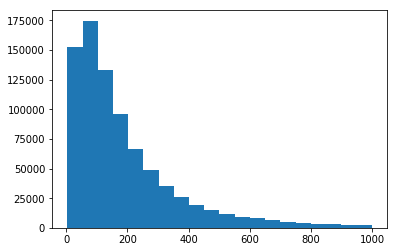

In [7]:
#histogram of comment length cut off at 1000 chars
plt.hist(full_df.loc[full_df['comment'].str.len() < 1000,'comment'].str.len(), bins=20);

The comment lengths appear to follow a log-normal distribution, which we confirm below by looking at a histogram of the logarithms of comment lengths.

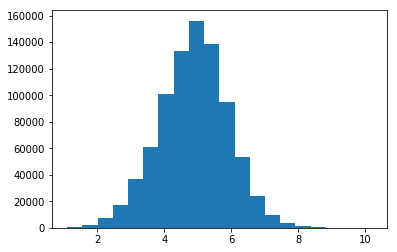

In [8]:
#histogram of log-transformed comment length
plt.hist(np.log(full_df['comment'].str.len()), bins=20);

### Rating Exploration

Next, we take a look at the distribution of ratings.

In [9]:
full_df['rating'].describe() #statistics for ratings

count    841643.000000
mean          7.201706
std           1.693762
min           1.000000
25%           6.000000
50%           7.100000
75%           8.000000
max          10.000000
Name: rating, dtype: float64

In [10]:
full_df['rating'].mode().values[0] #mode of ratings

7.0

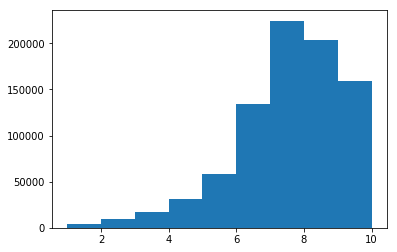

In [11]:
plt.hist(full_df['rating'], bins=9); #histogram of ratings

The ratings have a left-skewed distribution. However, note that it has a mode of 7.0, median of 7.1, and mean of 7.2, violating the usual rule of thumb that $mean < median < mode$ for a left-skewed distribution. In other words, despite the left-hand tail, the distribution is still heavy on the right side.

### Comment Length and Rating Relationship

One simple predictor of rating could be comment length; this would be a very easy feature to extract as input for a model. We do a preliminary investigation to see if this is worth using, plotting the variables against each other and getting a linear best-fit in order to understand their relation (if any).

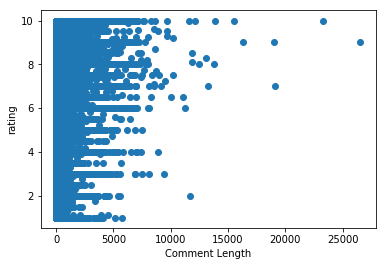

In [12]:
#plot rating against comment length
plt.scatter(full_df['comment'].str.len(), full_df['rating']);
plt.xlabel('Comment Length');
plt.ylabel('rating');

In [13]:
#find coefficients for least squares linear fit
comm_rating_fit = np.polyfit(full_df['comment'].str.len(), full_df['rating'], 1)

In [14]:
print('rating ≈ ' + str(comm_rating_fit[0]) + ' * comment_length + ' + str(comm_rating_fit[1]))

rating ≈ -1.601164966434114e-05 * comment_length + 7.205238324220927


Unfortunately, it seems like—though having extremely long comments tends to imply higher ratings—in the non-outlier data there is virtually no relationship (the coefficient for comment length in the linear fit is on the order of $10^{-5}$), so we shouldn't invest much in pursuing this.

### Use of Obvious Keywords

Another intuitive approach would be to use keywords with strong positive or negative connotations, looking for whether they appear in comments and using this to predict the rating. Before creating a model, we will see if the appearance of such keywords in a comment is in fact related to its rating. We use the arbitrarily selected positive keywords 'great', 'amazing', and 'fantastic', and the negative keywords 'awful', 'terrible', and 'worst'.

In [15]:
### make boolean arrays indicating which rows' comments include 
### positive-sentiment keywords 'great', 'amazing', 'fantastic'
great_bool = full_df['comment'].str.contains('great', case=False)
amaz_bool = full_df['comment'].str.contains('amazing', case=False)
fant_bool = full_df['comment'].str.contains('fantastic', case=False)

### use pandas array OR operator, |, to make boolean array indicating
### comments containing any positive word
pos_bool = great_bool | amaz_bool | fant_bool;

We can use the boolean series `pos_bool` defined above, which indicates which comments contain the positive keywords, to look at statistics for ratings that have keyword-containing comments versus those that don't.

Ratings of Comments Containing Positive Keywords
count    141943.000000
mean          7.827515
std           1.406630
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: rating, dtype: float64

Ratings of Comments Not Containing Positive Keywords
count    699700.000000
mean          7.074753
std           1.718680
min           1.000000
25%           6.000000
50%           7.000000
75%           8.000000
max          10.000000
Name: rating, dtype: float64


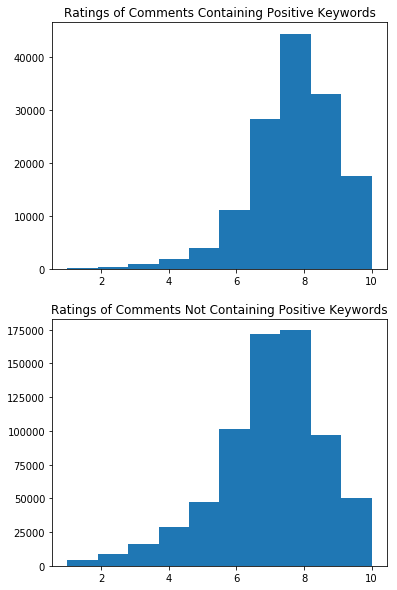

In [16]:
### statistics and histogram of ratings for comments
### that contain or don't contain positive keywords
print('Ratings of Comments Containing Positive Keywords')
print(full_df.loc[pos_bool, 'rating'].describe(), end='\n\n')
print('Ratings of Comments Not Containing Positive Keywords')
print(full_df.loc[~pos_bool, 'rating'].describe())
fig = plt.figure(figsize=(6, 10));
ax = fig.add_subplot(2, 1, 1);
ax.hist(full_df.loc[pos_bool, 'rating']);
ax.set_title('Ratings of Comments Containing Positive Keywords');
ax = fig.add_subplot(2, 1, 2);
plt.hist(full_df.loc[~pos_bool, 'rating']);
ax.set_title('Ratings of Comments Not Containing Positive Keywords');

The comments containing positive keywords have rating mean and median significantly higher than those that don't, and much fewer very low ratings.

We now repeat the same investigation for negative keywords.

In [17]:
#make boolean arrays indicating which rows' comments include 
#negative-sentiment words 'awful', 'terrible', 'worst'
awful_bool = full_df['comment'].str.contains('awful', case=False)
terr_bool = full_df['comment'].str.contains('terrible', case=False)
worst_bool = full_df['comment'].str.contains('worst', case=False)

#make boolean array for comments containing any 
neg_bool = awful_bool | terr_bool | worst_bool;

count    8010.000000
mean        5.771020
std         2.401574
min         1.000000
25%         4.000000
50%         6.000000
75%         7.500000
max        10.000000
Name: rating, dtype: float64


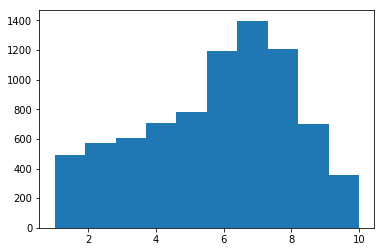

In [18]:
#statistics and histogram of ratings for comments that
#contained negative words
print(full_df.loc[neg_bool, 'rating'].describe())
plt.hist(full_df.loc[neg_bool, 'rating']);

count    833633.000000
mean          7.215453
std           1.679621
min           1.000000
25%           6.000000
50%           7.200000
75%           8.000000
max          10.000000
Name: rating, dtype: float64


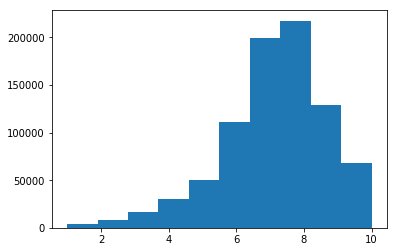

In [19]:
#statistics and histogram of ratings for comments that
#didn't contain negative words
print(full_df.loc[~neg_bool, 'rating'].describe())
plt.hist(full_df.loc[~neg_bool, 'rating']);

There is also a significant difference here. As an aside, we can notice that negative keywords discriminate better than positive.

## Crude Keyword Model

Having determined that keyword appearances in a comment for our chosen keywords is in fact meaningful for the comment's corresponding rating, we will make a first model using keywords (though, be warned, it will have the finesse of a sledgehammer). In particular, we will partition comments into four classes: those that contain mostly positive keywords, those that contain mostly negative keywords, those with an equal number of positive and negative keywords, and those containing neither positive nor negative keywords. 

The model will, given an input comment, determine the class of the comment and assign the mean score for training set comments of that class. We create the `crude_model` python class to encapsulate the model.

In [20]:
class crude_model(object):
    """Class that encapsulates a training data set and provides a 
    function that predicitively models rating based on input
    comment text."""
    
    def __init__(self, train_dat=None):
        if train_dat is not None:
            self.fit(train_dat)
            
    ### sets the training data
    def fit(self, train_dat):
        self.train_dat = train_dat
        self.train_dat['comment'] = self.train_dat['comment'].str.lower()
        
        ### make boolean array for location of positive keywords
        great_bool = train_dat['comment'].str.contains('great', case=False)
        amaz_bool = train_dat['comment'].str.contains('amazing', case=False)
        fant_bool = train_dat['comment'].str.contains('fantastic', case=False)
        self.pos_bool = great_bool | amaz_bool | fant_bool;
        
        ### make boolean array for location of negative keywords
        awful_bool = train_dat['comment'].str.contains('awful', case=False)
        terr_bool = train_dat['comment'].str.contains('terrible', case=False)
        worst_bool = train_dat['comment'].str.contains('worst', case=False)
        self.neg_bool = awful_bool | terr_bool | worst_bool;      
        
        ### separate training set into positive/negative/neutral, get means
        pos_dat = self.train_dat.loc[self.pos_bool, 'rating']
        self.pos_mean = pos_dat.mean()
        del pos_dat
        neg_dat = self.train_dat.loc[self.neg_bool, 'rating']
        self.neg_mean = neg_dat.mean()
        del neg_dat
        neutral_dat = self.train_dat.loc[~self.pos_bool & ~self.neg_bool, 'rating']
        self.neutral_mean = neutral_dat.mean()
        del neutral_dat
        self.all_mean = self.train_dat['rating'].mean()
    
    ### Predicts 1-10 rating (float) given comment rating (str)
    def predict(self, comment):
        comment = comment.lower()
        pos_count = sum(comment.count(wd) for wd in ('great', 'amazing', 'fantastic'))
        neg_count = sum(comment.count(wd) for wd in ('awful', 'terrible', 'worst'))
        if neg_count and pos_count:
            prediction = self.all_mean
        elif pos_count:
            prediction = self.pos_mean
        elif neg_count:
            prediction = self.neg_mean
        else:
            prediction = self.neutral_mean
        return prediction
    
    ### Get R^2 score for a test/validation set
    def score(self, comments, ratings, sample_weight=None):
        y_pred = [self.predict(comment) for comment in comments]
        y_pred = np.array(y_pred)
        return r2_score(ratings, y_pred, sample_weight=sample_weight)

With the model coded, we now need to split the comments into a training and test set. We shuffle the rows to avoid any bias due to ordering of the data set, and use an 80/20 split.

In [21]:
### get random train/test split of 80/20
np.random.seed(42) #fix random state for reproducability
inds = np.random.permutation(full_df.index)
test_size = int(np.ceil(0.2 * full_df.shape[0]))
test_inds = inds[:test_size]
train_inds = inds[test_size:]
test_df_2 = full_df.loc[test_inds]
train_df = full_df.loc[train_inds]

In [22]:
print(test_df_2.info(), end='\n\n')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168329 entries, 66639 to 823030
Data columns (total 4 columns):
rater_id    168329 non-null int64
game_id     168329 non-null int64
rating      168329 non-null float64
comment     168329 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 6.4+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 673314 entries, 780108 to 121958
Data columns (total 4 columns):
rater_id    673314 non-null int64
game_id     673314 non-null int64
rating      673314 non-null float64
comment     673314 non-null object
dtypes: float64(1), int64(2), object(1)
memory usage: 25.7+ MB
None


We can now train the model.

In [23]:
mdl_tst = crude_model(train_df) #train crude model of training set

In [24]:
actual_srs = test_df_2['rating'] #series of real ratings
predict_srs = test_df_2['comment'].apply(mdl_tst.predict) #series of predicted ratings

Finally, we evaluate our model's performance on the test set. We will provide the coefficient of determination $R^2$ and the root mean squared error. Additionally, we find the fraction of positive (above median) ratings that were predicted above median by the model (i.e. the sensitivity), the the fraction of negative (below median) ratings that were predicted below median by the model (i.e. the specificity), and the total accuracy of predicting over/under the median rating.

In [25]:
print('R^2:  ' + str(mdl_tst.score(test_df_2['comment'], actual_srs)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(actual_srs, predict_srs))))

R^2:  0.03396477804269726
RMSE: 1.6756858518056033


In [26]:
### Get boolean series representing whether actual/predicted rating is above median rating
actual_binary = (actual_srs > full_df['rating'].median())
predict_binary = (predict_srs > full_df['rating'].median())

### Get true positive/negative rates and 
true_pos = (actual_binary & predict_binary).sum() / predict_binary.sum()
true_neg = (~actual_binary & ~predict_binary).sum() / (~predict_binary).sum()
true_total = ((actual_binary & predict_binary) | (~actual_binary & ~predict_binary)).sum() 
true_total = true_total / predict_binary.shape[0]

print('Sensitivity (true positives rate): ' + str(true_pos))
print('Specificity (true negatives rate): ' + str(true_neg))
print('Total accuracy: ' + str(true_total))

Sensitivity (true positives rate): 0.6754349193041291
Specificity (true negatives rate): 0.5330808930373722
Total accuracy: 0.5572895935934985


Clearly, this model does not perform well. There are a couple of problems. First, our choice of keywords was made using guesswork, and while they aren't irrelevant, a more empirical approach would probably be useful. Second, the way in which the model maps keyword occurences to ratings is unsophisticated; for example, it can only assign one of four ratings to any comment.

## Refined Keyword Model

Our next step is to create a refined model that is still keyword-based but ameliorates the problems with the crude model we just discussed. 

To resolve the choice of keywords, we want to find those words that indicate more negative or more positive ratings. We will do this by getting all of the words used in comments (called a _lexicon_), counting the occurences of each word in positive and in negative comments, and then finding the _relative log-odds_ of the word appearing in positive versus negative comments. The log-odds will give a numeric score indicating how negative or positive a word is, with log-odds of zero indicating totally neutral words. We will then take some of the most negative and positive words as our keywords, and use the frequency of occurence of each of these keywords in a comment as our model's input.

In order to handle the second issue with the crude model, that we used an unsophisticated algorithm to assign ratings based on keyword occurences, will be solved by using two more sophisticated approaches: linear regression and a feed-forward neural network.

### Preprocessing and Feature Selection

First we need to clean the comments, so that for example punctuation marks are not included in words and capitalization is ignored. We do so by defining the following function.

In [27]:
def clean_comments(srs):
    """Transforms a series of strings into a standard form.
    
    Removes non-alphanumeric characters, deletes markup tags, replaces 
    dashes/slashes with spaces, and shortens multiple consecutive whitespaces.
    
    Args:
        srs: a pandas Series with string values.
    
    Returns:
        A Series containing strings in standardized form.
    """
    markup = re.compile(r"\[[^\]]+\]") #regex representing markup tags
    non_alpha = re.compile(r"[^a-zA-Z0-9\-\\\s]") #regex representing nonalphabetic chars
    multi_space = re.compile("\s+") #regex representing multiple spaces
    
    clean_srs = srs.str.replace(markup, "") #delete markup
    clean_srs = clean_srs.str.replace(non_alpha, "") #delete nonalphabetic chars
    clean_srs = clean_srs.str.replace("\\", " ") #replace slashes with spaces
    clean_srs = clean_srs.str.replace("-", " ") #replace dashes with spaces
    clean_srs = clean_srs.str.replace(multi_space, " ") #trim multiple spaces
    
    clean_srs = clean_srs.str.strip() #strip leading/trailing whitespace
    clean_srs = clean_srs.str.lower() #change to lower case
    return clean_srs

In [28]:
clean_comments(full_df['comment'].head(20))

66639     good unique take on the hidden role games the ...
71481     a neat social deduction game with multiple tea...
93026     good hidden roles werewolf style game that can...
696037    overall i hate mafiawerewolf but this version ...
297346    fun social deduction exercise that gets merrie...
489803    this is really part of the base set and i woul...
416429                                  we love the builder
493452    every carc original game gets played with this...
151670        must have should be included in the base game
429820            probably the greatest expansion ever made
342292           the more the merrier better for the cylons
234440    great game mechanics are really simple but the...
771182    i love this game only hit the table on one occ...
550400    love the tension and theme i played with mostl...
668905    puntuacion oca 8 eban 10 seldonita 8 partidas ...
419714                                  paranoia everywhere
840091    played twice over the weekend 

Next, we need to retrieve a lexicon consisting of all of the words that occurr in the comments. We will use the below function to do so; it can process comments in batches in order to reduce memory overhead.

In [29]:
def lexicon(srs, batch_size=None, clean=False):
    """Gets a lexicon of words used in a series of strings.
    
    Args:
        srs: a pandas Series with string values.
        batch_size: number of strings to process into the
            lexicon at each iteration. If None, then only do
            one iteration with all strings.
        clean: whether to first apply clean_comments() to srs.
    
    Returns:
        A Set containing all words in the comments.
    """
    ### preprocess comments if necessary
    if clean:
        srs = clean_comments(srs)
        
    if batch_size is None:
        ### if not using batches, simply concatenate and split
        ### all comments at once, then delete duplicates
        lex = srs.str.cat(sep=' ').split()
        lex = set(lex)
    else:
        ### if using batches, load in one batch at a time,
        ### adding to lexicon and deleting duplicates as it 
        ### goes to save memory.
        lex = set([])
        batches = 1 + srs.shape[0] // batch_size
        for i in range(batches):
            start = batch_size * i
            if i < batches - 1:
                stop = batch_size * (i + 1)
            else:
                stop = -1
            batch = srs.iloc[start:stop].str.cat(sep=' ')
            batch = set(batch.split())
            lex = lex.union(batch)
    return lex

With the `lexicon` function, we can now get the desired lexicon.

In [30]:
### get lexicon for our dataset
lex = list(lexicon(train_df['comment'], batch_size=1024, clean=True)) #get as list
lex.sort() #sort alphabetically

We now take subsets of the comments, getting positive comments (those with ratings of at least 8) and negative ones (those with ratings below 6). We don't use those with ratings of around 7, since those are fairly neutral (recall that the ratings median is 7.1).

In [31]:
### split comments into positive and negative sets
pos_df = train_df.loc[train_df['rating'] >= 8]
neg_df = train_df.loc[train_df['rating'] <= 6]

### get cleaned positive/negative comments
comments_pos = clean_comments(pos_df['comment'])
comments_neg = clean_comments(neg_df['comment'])

We now make a table that counts the occurences of the words in the lexicon in positive and negative comments.

In [32]:
pos_occur_dict = {}
neg_occur_dict = {}
for word in lex:
    pos_occur_dict[word] = 0
    neg_occur_dict[word] = 0
    
comments_pos_split = comments_pos.str.split()
comments_neg_split = comments_neg.str.split()
for comment in comments_pos_split:
    for word in comment:
        try:
            pos_occur_dict[word] += 1
        except KeyError:
            pos_occur_dict[word] = 1
for comment in comments_neg_split:
    for word in comment:
        try:
            neg_occur_dict[word] += 1
        except KeyError:
            neg_occur_dict[word] = 1

occur_data = {'positive':[], 'negative':[]}
for word in lex:
    occur_data['positive'].append(pos_occur_dict.pop(word))
    occur_data['negative'].append(neg_occur_dict.pop(word))
occur_data = pd.DataFrame(data=occur_data, index=lex)
occur_data

,positive,negative
0,649,339
00,21,7
000,8,0
0000,1,0
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001,0,1
00000001,0,1
0001,2,0
00010,0,1
000123,1,0
0002,1,0


In [33]:
(occur_data['positive'] + occur_data['negative']).describe()

count    144995.000000
mean        132.149847
std        4676.141506
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max      894020.000000
dtype: float64

We can see that there are a lot of words that are very rare. Since some of these might occur in more positive than negative comments, or vice versa, they could receive large-magnitude log-odds. They would then be included in our keywords, despite not being useful because they don't occur in many comments; even worse, the log-odds would be more susceptible to noise due to the small sample size. To avoid this, we first filter out all but the most common 10% of the lexicon.

In [34]:
# take words that occur at least twice in both positive and negative comments
freq_occur_dat = occur_data.loc[(occur_data['positive'] >= 1) & (occur_data['negative'] >= 1)]
### take top 10% most frequent words only
upper_percentile = np.percentile(freq_occur_dat['positive'] + freq_occur_dat['negative'], 90.)
freq_occur_dat = freq_occur_dat.loc[freq_occur_dat['positive'] + freq_occur_dat['negative'] > upper_percentile]
freq_occur_dat.head(10)

,positive,negative
0,649,339
01,260,184
02,151,156
03,159,153
04,143,140
05,216,210
06,193,138
07,252,168
08,283,177
09,293,190


We now find the relative log-odds for the lexicon. Given a word, the log-odds that an arbitrary positive comment contains that word is
$$P_1 = \log\left( \frac{p_1}{1 - p_1} \right).$$
Here, $p_1$ is the probability that the word occurs in the positive comment, given by
$$p_1 = \frac{n_1}{N_1},$$
where $n_1$ is the number of positive comments the word appears in and $N_1$ is the total number of positive comments. Similarly, for the log-odds $P_2$ that the word occurs in a randomly selected negative comment, we have
$$P_2 = \log\left( \frac{p_2}{1 - p_2} \right).$$
The relative log-odds for the word is then defined as
$$\log\left( \frac{p_1\,/\,(1-p_1)}{p_2\,/\,(1-p_2)} \right) = \log\left( \frac{p_1}{1 - p_1} \right) - \log\left( \frac{p_2}{1 - p_2} \right) = P_1 - P_2.$$

In [35]:
### Find log-odds for words occuring in positive/negative comments
pos_log_odds = freq_occur_dat['positive'] / comments_pos.shape[0]
neg_log_odds = freq_occur_dat['negative'] / comments_neg.shape[0]
pos_log_odds = (pos_log_odds / (1 - pos_log_odds)).apply(np.log)
neg_log_odds = (neg_log_odds / (1 - neg_log_odds)).apply(np.log)

### Find relative log-odds that words will be in positive comments
### rather than negative
compare_log_odds = pos_log_odds - neg_log_odds
compare_log_odds = compare_log_odds.dropna()
compare_log_odds = compare_log_odds.sort_values(ascending=False)

### Print top and bottom 50 words by log-odds
for ind in compare_log_odds.head(50).index:
    print(ind + '\n' + str(compare_log_odds[ind]), end='\n\n')
print(60*'-', end='\n\n')
for ind in compare_log_odds.sort_values().head(50).index:
    print(ind + '\n' + str(compare_log_odds[ind]), end='\n\n')

perfection
2.5034653450794737

masterpiece
2.2223725058914434

favourites
2.1796546229104203

1010
2.0103825663502732

85
1.9426480914588833

fantastic
1.9022033398549612

starstarstarstarstar
1.8681185668769844

superb
1.8525690425939256

810
1.8162438100403921

finest
1.8063859588375362

outstanding
1.7758643189959855

brilliantly
1.7666859161255957

favorites
1.7352362200252829

addicted
1.7305196333753656

mayday
1.7185973541208552

910
1.7108547358100035

brilliant
1.6874585387968697

excellent
1.6655848471248746

addicting
1.661190374578947

premium
1.6427389746386787

hooked
1.627010239696161

amazing
1.6186885929333563

incredible
1.611469328744592

terrorist
1.6068330034928548

addictive
1.5948133156341395

awesome
1.5895795563061292

wonderful
1.5862371556638681

brink
1.5834725656606503

wonderfully
1.5724300359003367

genius
1.5723172968401675

terrific
1.5723172968401675

favourite
1.5463899937436052

strain
1.5195694865043539

deceptively
1.5073413324145326

phenomenal
1.

Looking over these words—the most positive of which contain words like "masterpiece" or "fantastic" and the most negative featuring words like "uninteresting", "overrated", and "meh"—it seems at first glance that the log-odds selection process worked well. We visualize the log-odds across our lexicon below.

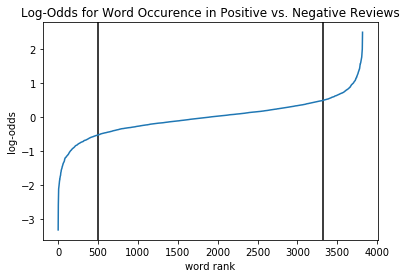

In [36]:
plt.title('Log-Odds for Word Occurence in Positive vs. Negative Reviews')
plt.xlabel('word rank')
plt.ylabel('log-odds')
plt.axvline(x=500, c='k')
plt.axvline(x=(freq_occur_dat.shape[0] - 500), c='k')
pd.Series(data=compare_log_odds.sort_values().tolist(), index=range(compare_log_odds.shape[0])).plot();

The black lines show our cutoffs: we will take the 500 most positive and 500 most negative words as our keywords.

In [37]:
keywords = compare_log_odds.head(500).index.tolist() 
keywords += compare_log_odds.tail(500).index.tolist()

In order to obtain our input features, for each comment we need to count how many times the keywords appear in it. We then normalize by dividing by the total number of words in the comment, yielding an occurence rate of the keyword. This last part is an important preprocessing step that helps to account for comment length, so our model doesn't over- or under-rate very long comments (or, conversely, treat short comments as neutral).

In [38]:
word_counts = {}
for word in keywords:
    word_counts[word] = np.zeros(train_df.shape[0], dtype=int)
word_counts['comment_length'] = np.zeros(train_df.shape[0], dtype=int)
for i, comment in enumerate(clean_comments(train_df['comment']).str.split()):
    word_counts['comment_length'][i] = len(comment)
    for word in comment:
        if word in word_counts:
            word_counts[word][i] += 1
word_counts = pd.DataFrame(data=word_counts, index=train_df.index)
word_counts['rating'] = train_df['rating']

train_input = word_counts.iloc[:,:-2].apply(lambda col: col / word_counts.iloc[:,-2], 
                                            axis=0
                                           )
train_input = train_input.dropna(axis=0)
train_target = word_counts.loc[train_input.index].iloc[:,-1]
train_target = (2 * train_target).round() / 2

del word_counts

In [39]:
word_counts_test = {}
for word in keywords:
    word_counts_test[word] = np.zeros(test_df_2.shape[0], dtype=int)
word_counts_test['comment_length'] = np.zeros(test_df_2.shape[0], dtype=int)
for i, comment in enumerate(clean_comments(test_df_2['comment']).str.split()):
    word_counts_test['comment_length'][i] = len(comment)
    for word in comment:
        if word in word_counts_test:
            word_counts_test[word][i] += 1
word_counts_test = pd.DataFrame(data=word_counts_test, index=test_df_2.index)
word_counts_test['rating'] = test_df_2['rating']

test_input = word_counts_test.iloc[:,:-2].apply(lambda col: col / word_counts_test.iloc[:,-2], 
                                            axis=0
                                           ).dropna(axis=0)
test_target = word_counts_test.loc[test_input.index].iloc[:,-1]
test_target = (2 * test_target).round() / 2

del word_counts_test

### Linear Regression Model

We now train a simple linear regression model.

In [40]:
refined_model = linear_model.LinearRegression()

In [41]:
refined_model.fit(train_input, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
predictions = np.clip(refined_model.predict(test_input), 1, 10)

In [43]:
print(refined_model.score(test_input, test_target)) #R^2 score
np.sqrt(mean_squared_error(test_target, predictions)) #RMSE score

0.229041909795336


1.4922588952295492

In [44]:
line_coeffs = np.polyfit(test_target, predictions, 1)

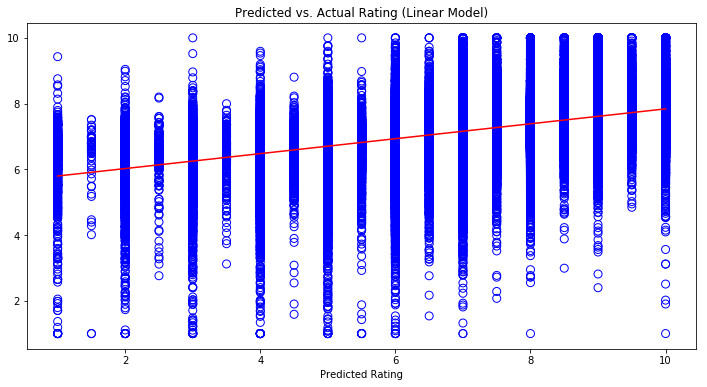

In [45]:
plt.figure(figsize=(12, 6));
plt.scatter(test_target, predictions, s=64, marker='o', facecolors='none', edgecolors='b', linewidths=1.);
plt.plot(np.arange(1, 10.1, 0.1), [line_coeffs[0]*x + line_coeffs[1] for x in np.arange(1, 10.1, 0.1)], c='r');
plt.title('Predicted vs. Actual Rating (Linear Model)');
plt.xlabel('Actual Rating');
plt.xlabel('Predicted Rating');

Because the ratings tend to cluster in multiples of 0.5, a clear way to visualize our model's performance is to round true ratings to the nearest 0.5 and make a box plot of the predicted scores for each of the ratings. 

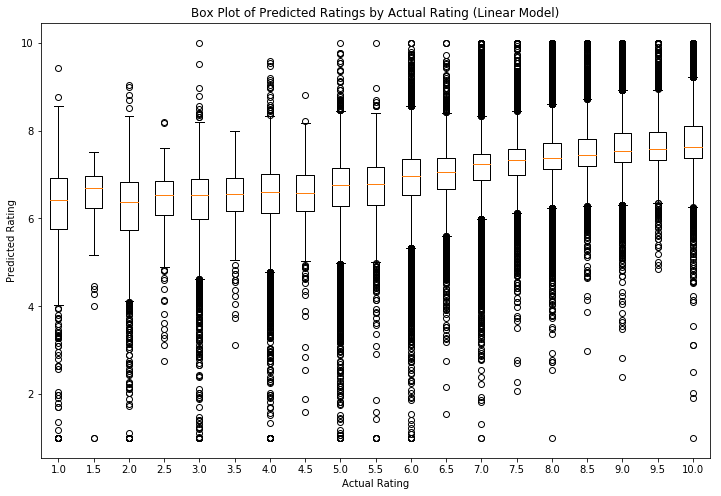

In [46]:
pair_dict = {}
for x in np.arange(1., 10.5, 0.5):
    pair_dict[x] = predictions[test_target == x]

plt.figure(figsize=(12, 8));
plt.boxplot(pair_dict.values());
xtick_locs = plt.xticks()[0];
plt.xticks(xtick_locs, pair_dict.keys());
plt.xlabel('Actual Rating');
plt.ylabel('Predicted Rating');
plt.title('Box Plot of Predicted Ratings by Actual Rating (Linear Model)');

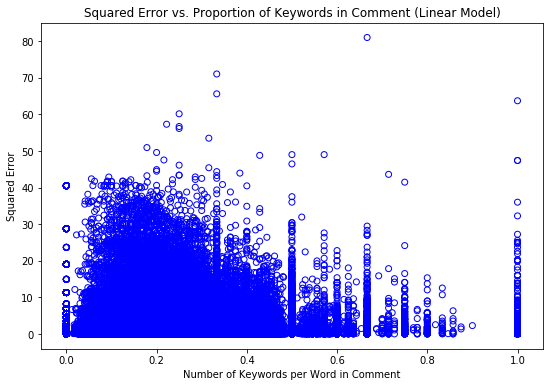

In [47]:
plt.figure(figsize=(9, 6));
plt.scatter(test_input.sum(axis=1), (predictions - test_target)**2, 
            marker='o', facecolors='none', edgecolors='b', linewidths=1.
           );
plt.title('Squared Error vs. Proportion of Keywords in Comment (Linear Model)');
plt.xlabel('Number of Keywords per Word in Comment');
plt.ylabel('Squared Error');

### Feedforward Neural Network Model

One problem with a linear model is that it is not able to capture more complex relationships between the input features, such as the interaction that happens when keywords co-occur. A neural network is better able to use those relationships to predict the rating, so we will train a feedforward neural network (multilayer perceptron) with two hidden layers.

In [48]:
mlp_model = neural_network.MLPRegressor(hidden_layer_sizes=(256, 256), activation='tanh', random_state=42)

In [49]:
mlp_model.fit(train_input, train_target) #train model

### save serialized model
with open('data/mlp_model.pkl', 'wb') as file:
    pickle.dump(mlp_model, file)

In [50]:
mlp_predictions = np.clip(mlp_model.predict(test_input), 1, 10)

In [51]:
print('R^2:  ' + str(mlp_model.score(test_input, test_target))) #R^2 score
print('RMSE: ' + str(np.sqrt(mean_squared_error(test_target, mlp_predictions)))) #RMSE score

R^2:  0.31117569444143933
RMSE: 1.4155525611812074


In [52]:
mlp_line_coeffs = np.polyfit(test_target, predictions, 1)

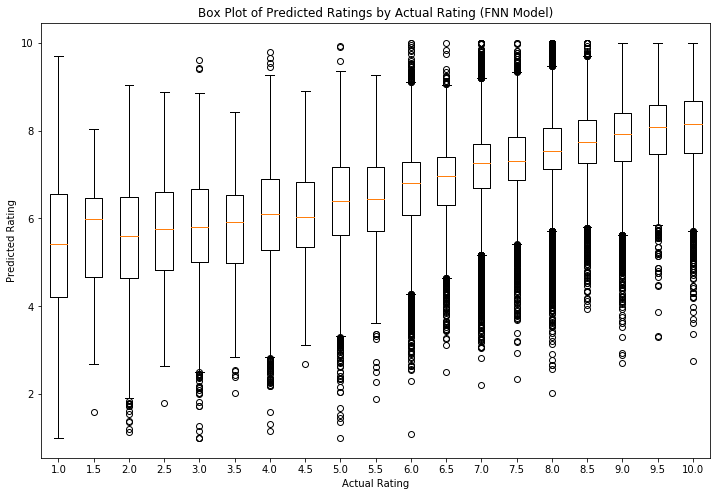

In [53]:
mlp_pair_dict = {}
for x in np.arange(1., 10.5, 0.5):
    mlp_pair_dict[x] = mlp_predictions[test_target == x]

plt.figure(figsize=(12, 8));
plt.boxplot(mlp_pair_dict.values());
xtick_locs = plt.xticks()[0];
plt.xticks(xtick_locs, mlp_pair_dict.keys());
plt.xlabel('Actual Rating');
plt.ylabel('Predicted Rating');
plt.title('Box Plot of Predicted Ratings by Actual Rating (FNN Model)');

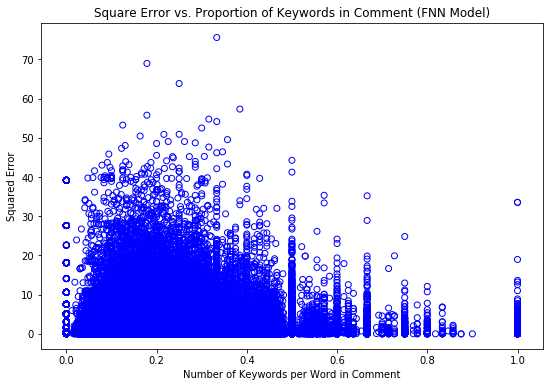

In [54]:
plt.figure(figsize=(9, 6));
plt.scatter(test_input.sum(axis=1), (mlp_predictions - test_target)**2, 
            marker='o', facecolors='none', edgecolors='b', linewidths=1.
           );
plt.title('Square Error vs. Proportion of Keywords in Comment (FNN Model)');
plt.xlabel('Number of Keywords per Word in Comment');
plt.ylabel('Squared Error');